This notebook will be used with the aim of showing how a logistic regression works:

# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

import category_encoders as ce

In [2]:
import warnings

warnings.simplefilter("ignore")

# 3. Define global variables

In [3]:
INPUT_PATH = "../../data/credit_card_data/data_modified_binary_classification.csv"

# 4. Functions

# 5. Code

We are going to make use of some credit card details data. The data is calculated in the notebook *00_transform_data_binary_classification.ipynb*. All needed information about the data is sotred there.

## 5.1. Load and transform data

First of all we are going to load the both the data and the target variables making use of pandas library

In [4]:
data = pd.read_csv(INPUT_PATH, sep=";")
data.head()

,car_owner,propert_owner,children,type_income,education,marital_status,housing_type,employed_days,mobile_phone,work_phone,phone,email_id,family_members,target
0,Y,Y,0,Pensioner,Higher education,Married,House / apartment,365243,1,0,0,0,2,1
1,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
2,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
3,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
4,Y,N,0,Pensioner,Higher education,Married,House / apartment,-586,1,1,1,0,2,1


### Train / test split

Before doing transformations in the data, we need to divide it into train and test. **Let's remember that all transformations must be fitted in the training dataset**

In [5]:
X = data.drop("target", axis=1)
y = data["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
y_train.value_counts(normalize=True)

0    0.894845
1    0.105155
Name: target, dtype: float64

In [8]:
y_test.value_counts(normalize=True)

0    0.915865
1    0.084135
Name: target, dtype: float64

We need to transform all categorical columns to numeric. First, let's detect them:

In [9]:
categorical_cols = data.select_dtypes(include="object").columns

We are going to use target encoder in order to transform the categorical data:

In [10]:
target_encoder = ce.TargetEncoder(cols = categorical_cols)

In [11]:
X_train_processed = target_encoder.fit_transform(X_train, y_train)
X_test_processed = target_encoder.transform(X_test)

Would it be correct to run a logistic regression with this data? NO

The data must be standarized in order to compare coeffiecients when the logistic regression is calculated

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

## 5.2. Training

Let's initialize the model and train it then:

In [13]:
model = LogisticRegression(random_state=42)

model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

Once the model is trained, let's calculate predictions of the X_test_scaled data:

In [14]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

## 5.3. Metrics calculation

First, let's calculate some metrics and show them:

In [15]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [16]:
print(f"The accuracy error value is: {accuracy}")
print(f"The roc_auc value is: {roc_auc}")

The accuracy error value is: 0.9134615384615384
The roc_auc value is: 0.6119610048743906


Now we will plot both the confusion matrix and the roc curve:

**Confusion matrix:**

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

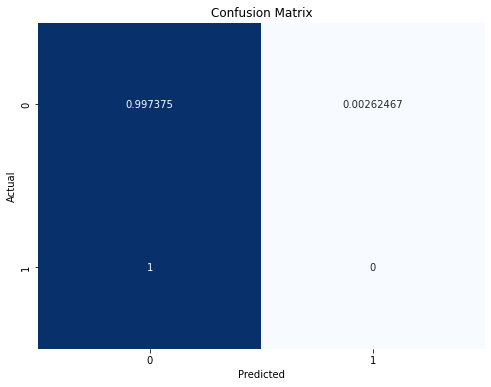

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe a very bad result for the confusion matrix. This is because of the threshold considered when calculating y_pred. We need to modify this threshold. We are considering the value 0.1 because is the default imbalance value:

In [19]:
y_pred_new = np.where(y_pred_proba >= 0.1, 1, 0)

In [20]:
accuracy = accuracy_score(y_test, y_pred_new)
print(f"The accuracy error value is: {accuracy}")

The accuracy error value is: 0.6322115384615384


In [21]:
conf_matrix = confusion_matrix(y_test, y_pred_new, normalize="true")

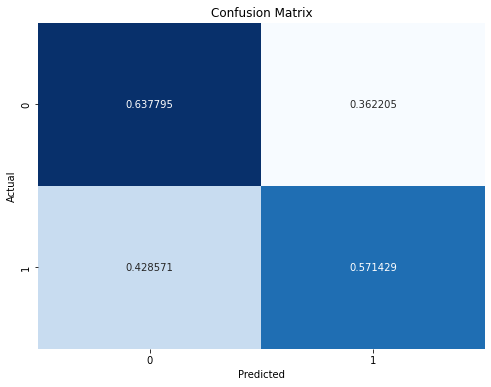

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe a better performance of the model now. However, let's remember that this is for logistic regression understanding purposes only. If we would like to find the best model, we should have to be more cautious and more precise when selecting the threshold

**ROC Curve:**

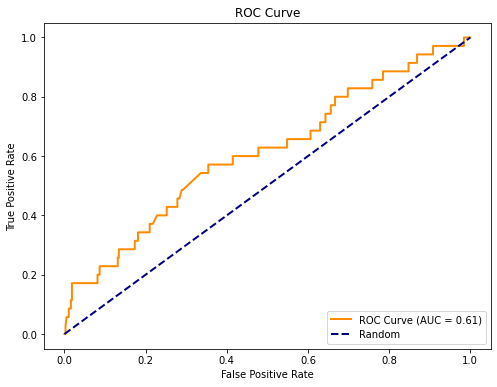

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {round(roc_auc, 2)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

A 0.61 value in AUC gives us the clue that the model has some ability to discriminate between positive and negative instances. It is not a very sharp model, but the model's discriminatory power is slightly better than random guessing. 

## 5.4. Interpretion

Let's attend at the coefficient values a moment:

In [37]:
coef_df = pd.DataFrame({'Feature': list(X_train.columns) + ["intercept"], 
                        'Coefficient': list(model.coef_[0]) + [model.intercept_[0]]})
coef_df

,Feature,Coefficient
0,car_owner,0.076221
1,propert_owner,0.008550
2,children,-0.448836
3,type_income,0.645390
4,education,0.187490
5,marital_status,0.424661
6,housing_type,0.280172
7,employed_days,-0.382355
8,mobile_phone,0.000000
9,work_phone,-0.094102


The strongest coefs are the type_income and family_members variables. This makes a lot of sense considering that our dataset is about credit card application approved or not. 

Results show that we are in front of a not so good model but not so bad model also. Maybe a consideration of hyperparameter tunning or a tree based algorithm would give us the boost in order to get better results.